# Using Albumentations with Tensorflow

**Author**: [Ayushman Buragohain](https://github.com/benihime91)

## Prepare the Google Colab environment

#### Download images

Download images that are used in the notebook and save to the `images` folder in the Colab environment.

In [ ]:
!wget -q https://github.com/albumentations-team/albumentations_examples/archive/master.zip -O /tmp/albumentations_examples.zip
!unzip -o -qq /tmp/albumentations_examples.zip -d /tmp/albumentations_examples
!cp -r /tmp/albumentations_examples/albumentations_examples-master/notebooks/images .
!echo "Images are successfully downloaded"

#### Install the latest version of Albumentations

Google Colab has an outdated version of Albumentations so we will install the latest stable version from PyPi.

In [ ]:
!pip install -q -U albumentations
!echo "$(pip freeze | grep albumentations) is successfully installed"

## Run the example

In [1]:
# necessary imports
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from functools import partial
from albumentations import (
    Compose, RandomBrightness, JpegCompression, HueSaturationValue, RandomContrast, HorizontalFlip,
    Rotate
)
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [2]:
# load in the tf_flowers dataset
data, info= tfds.load(name="tf_flowers", split="train", as_supervised=True, with_info=True)
data

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset tf_flowers downloaded and prepared to /Users/alexparinov/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>

In [3]:
info

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

## An Example Pipeline Using `tf.image`

## Process Data

In [4]:
def process_image(image, label, img_size):
    # cast and normalize image
    image = tf.image.convert_image_dtype(image, tf.float32)
    # apply simple augmentations
    image = tf.image.random_flip_left_right(image)
    image = tf.image.resize(image,[img_size, img_size])
    return image, label

ds_tf = data.map(partial(process_image, img_size=120), num_parallel_calls=AUTOTUNE).batch(30).prefetch(AUTOTUNE)
ds_tf

<PrefetchDataset shapes: ((None, 120, 120, 3), (None,)), types: (tf.float32, tf.int64)>

## View images from the dataset

In [5]:
def view_image(ds):
    image, label = next(iter(ds)) # extract 1 batch from the dataset
    image = image.numpy()
    label = label.numpy()
    
    fig = plt.figure(figsize=(22, 22))
    for i in range(20):
        ax = fig.add_subplot(4, 5, i+1, xticks=[], yticks=[])
        ax.imshow(image[i])
        ax.set_title(f"Label: {label[i]}")

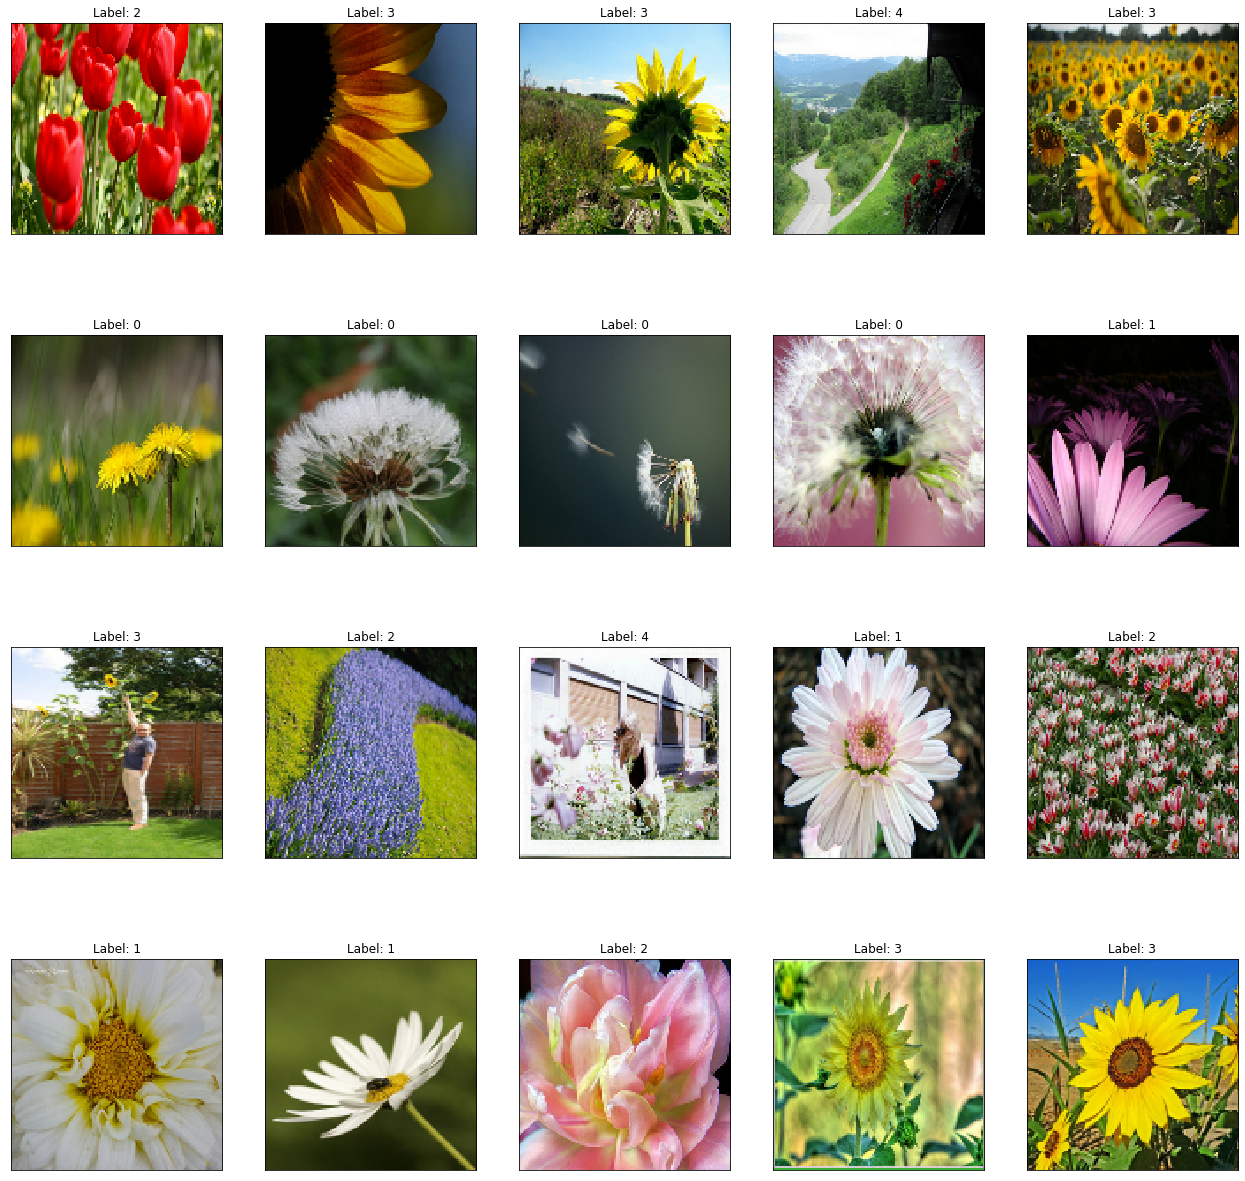

In [6]:
view_image(ds_tf)

Using `tf.image` is very efficient to create a pipeline but the disadvantage is that with `tf.image` we can only apply limited amount of augmentations to out `input data`.
One way to solve is issue is to use `tf.keras` `ImageDataGenerator` class but `albumentations` is faster.

# An Example Pipeline using `albumentations`

To integrate `albumentations` into our tensorflow pipeline we can create two function :
    1. pipeline to apply augmentation
    2. a function that calls the above function and passes in our data through the pipeline.
We can then wrap our 2nd Function under `tf.numpy_function` .

## Create Pipeline to Process data

In [7]:
# Instantiate augments
# we can apply as many augments we want and adjust the values accordingly
# here I have chosen the augments and their arguments at random
transforms = Compose([
            Rotate(limit=40),
            RandomBrightness(limit=0.1),
            JpegCompression(quality_lower=85, quality_upper=100, p=0.5),
            HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
            RandomContrast(limit=0.2, p=0.5),
            HorizontalFlip(),
        ])

In [8]:
def aug_fn(image, img_size):
    data = {"image":image}
    aug_data = transforms(**data)
    aug_img = aug_data["image"]
    aug_img = tf.cast(aug_img/255.0, tf.float32)
    aug_img = tf.image.resize(aug_img, size=[img_size, img_size])
    return aug_img

In [9]:
def process_data(image, label, img_size):
    aug_img = tf.numpy_function(func=aug_fn, inp=[image, img_size], Tout=tf.float32)
    return aug_img, label

In [10]:
# create dataset
ds_alb = data.map(partial(process_data, img_size=120),
                  num_parallel_calls=AUTOTUNE).batch(32).prefetch(AUTOTUNE)

## View images from the dataset

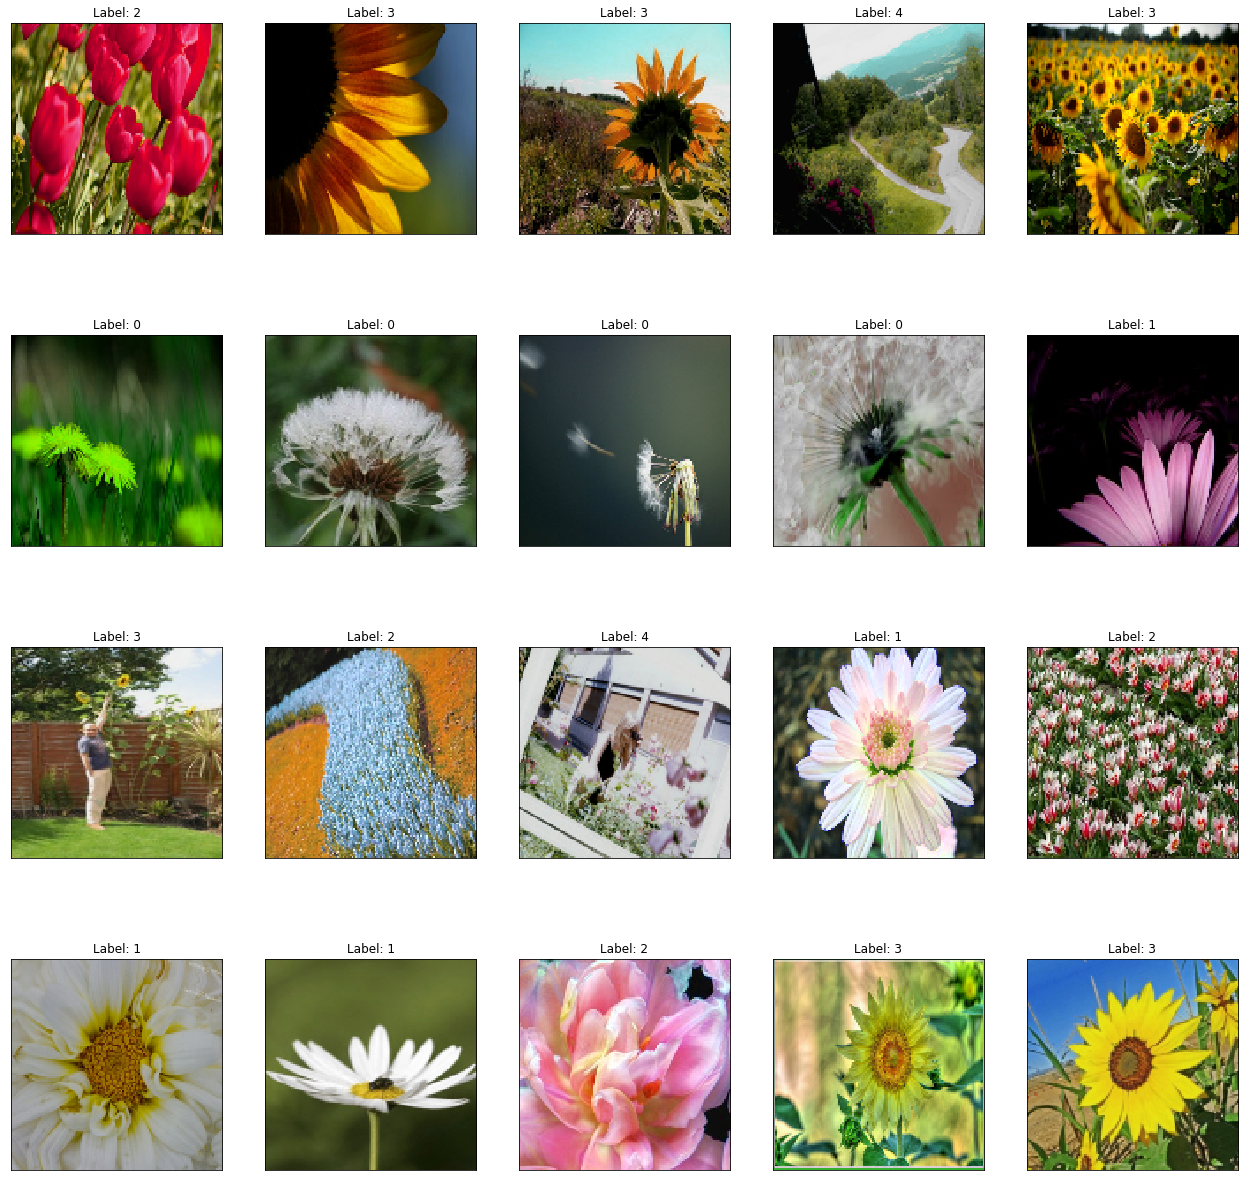

In [11]:
view_image(ds_alb)

**We can then pass in this dataset to out model and call `fit` on our model**